In [1]:
train_dir = r"C:\Users\rafci\Desktop\tensorflow-speech-recognition-challenge\train"

In [2]:
import numpy as np
import os

In [3]:
X_train = np.load("data/X_train.npy")
y_train = np.load("data/y_train.npy")

X_val = np.load("data/X_val.npy")
y_val = np.load("data/y_val.npy")

In [4]:
print(y_val)

[ 0  0  0 ... 21 21 21]


In [5]:
print(X_train.shape)
print(y_train.shape)

(58284, 122, 85, 1)
(58284,)


In [6]:
X_train = X_train.reshape((-1, X_train.shape[1], X_train.shape[2]))
X_val = X_val.reshape((-1, X_val.shape[1], X_val.shape[2]))

In [7]:
classes = os.listdir(train_dir+'/audio/')
classes

['bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'four',
 'go',
 'happy',
 'house',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'silence',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'wow',
 'yes',
 'zero']

In [8]:
from collections import Counter

def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return {cls: float(majority/count) for cls, count in counter.items()}

class_weights = get_class_weights(y_train)
class_weights

{0: 1.4116094986807388,
 1: 1.3639260675589548,
 2: 1.3674121405750799,
 3: 1.3578680203045685,
 4: 1.0214797136038185,
 5: 1.0146989094357515,
 6: 1.011820330969267,
 7: 1.022944550669216,
 8: 1.0132575757575757,
 9: 1.3779781068898906,
 10: 1.357006975269499,
 11: 1.0161443494776827,
 12: 1.3493064312736445,
 13: 1.0028116213683225,
 14: 1.0166270783847982,
 15: 1.0185625892432175,
 16: 1.014218009478673,
 17: 1.0,
 18: 1.0137375651350071,
 19: 1.012298959318827,
 20: 1.373555840821566,
 21: 5.92797783933518,
 22: 1.0156620787850024,
 23: 1.0028116213683225,
 24: 1.015180265654649,
 25: 1.3656668793873643,
 26: 1.0014038371548901,
 27: 1.011820330969267,
 28: 1.3552881570614312,
 29: 1.011342155009452,
 30: 1.011342155009452}

In [9]:
NB_CLASSES = len(classes)

In [10]:
def convert_list_dict(lst):
    res_dct = {i: val for i, val in enumerate(lst)}
    return res_dct
         
classes_index = convert_list_dict(classes)
classes_index

{0: 'bed',
 1: 'bird',
 2: 'cat',
 3: 'dog',
 4: 'down',
 5: 'eight',
 6: 'five',
 7: 'four',
 8: 'go',
 9: 'happy',
 10: 'house',
 11: 'left',
 12: 'marvin',
 13: 'nine',
 14: 'no',
 15: 'off',
 16: 'on',
 17: 'one',
 18: 'right',
 19: 'seven',
 20: 'sheila',
 21: 'silence',
 22: 'six',
 23: 'stop',
 24: 'three',
 25: 'tree',
 26: 'two',
 27: 'up',
 28: 'wow',
 29: 'yes',
 30: 'zero'}

In [11]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=NB_CLASSES)
y_val = to_categorical(y_val, num_classes=NB_CLASSES)

In [12]:
from keras.layers import Conv1D, MaxPool1D, Concatenate, BatchNormalization, Activation, Input, Add, \
                         GlobalAveragePooling1D, Dense
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from livelossplot import PlotLossesKeras
from tensorflow.keras.metrics import Recall, Precision
import keras
import time

In [13]:
import tensorflow.keras.backend as K

def f1_score(y_true, y_pred):    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [14]:
class Classifier_INCEPTION:
    def __init__(self, weights_directory, input_shape, nb_classes, verbose=False, build=True, batch_size=64,
                 nb_filters=32, use_residual=True, use_bottleneck=True, depth=10, kernel_size=41, nb_epochs=1):
        self.weights_directory = weights_directory
        self.nb_filters = nb_filters
        self.use_residual = use_residual
        self.use_bottleneck = use_bottleneck
        self.depth = depth
        self.kernel_size = kernel_size - 1
        self.callbacks = None
        self.batch_size = batch_size
        self.bottleneck_size = 32
        self.nb_epochs = nb_epochs

        if build == True:
            self.model = self.build_model(input_shape, nb_classes)
            if (verbose == True):
                self.model.summary()
            self.verbose = verbose

    def _inception_module(self, input_tensor, stride=1, activation='linear'):

        if self.use_bottleneck and int(input_tensor.shape[-1]) > 1:
            input_inception = Conv1D(filters=self.bottleneck_size, kernel_size=1,
                                     padding='same', activation=activation, use_bias=False)(input_tensor)
        else:
            input_inception = input_tensor

        kernel_size_s = [self.kernel_size // (2 ** i) for i in range(3)]

        conv_list = []

        for i in range(len(kernel_size_s)):
            conv_list.append(Conv1D(filters=self.nb_filters, kernel_size=kernel_size_s[i],
                                    strides=stride, padding='same', activation=activation, use_bias=False)(
                input_inception))

        max_pool_1 = MaxPool1D(pool_size=3, strides=stride, padding='same')(input_tensor)

        conv_6 = Conv1D(filters=self.nb_filters, kernel_size=1,
                        padding='same', activation=activation, use_bias=False)(max_pool_1)

        conv_list.append(conv_6)

        x = Concatenate(axis=2)(conv_list)
        x = BatchNormalization()(x)
        x = Activation(activation='relu')(x)
        return x

    def _shortcut_layer(self, input_tensor, out_tensor):
        shortcut_y = Conv1D(filters=int(out_tensor.shape[-1]), kernel_size=1,
                            padding='same', use_bias=False)(input_tensor)
        shortcut_y = BatchNormalization()(shortcut_y)

        x = Add()([shortcut_y, out_tensor])
        x = Activation('relu')(x)
        return x

    def build_model(self, input_shape, nb_classes):
        input_layer = Input(input_shape)

        x = input_layer
        input_res = input_layer

        for d in range(self.depth):

            x = self._inception_module(x)

            if self.use_residual and d % 3 == 2:
                x = self._shortcut_layer(input_res, x)
                input_res = x

        gap_layer = GlobalAveragePooling1D()(x)

        output_layer = Dense(nb_classes, activation='softmax')(gap_layer)

        model = Model(inputs=input_layer, outputs=output_layer)

        model.compile(loss='categorical_crossentropy', 
                      optimizer=Adam(),
                      metrics=['accuracy', Precision(), Recall(), f1_score])

        reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                                      factor=0.5, 
                                      patience=int(self.nb_epochs/20),
                                      min_lr=0.0001)
        
        file_path = os.path.join(self.weights_directory,"best_weights.keras")
        model_checkpoint = ModelCheckpoint(filepath=file_path, 
                                           monitor='val_accuracy',
                                           mode="max",
                                           save_best_only=True)
        
        early_stopping = EarlyStopping(monitor="val_accuracy", 
                                       mode="max", 
                                       verbose=1, 
                                       patience=int(self.nb_epochs/10))
        plotlosses = PlotLossesKeras()
        self.callbacks = [reduce_lr, model_checkpoint, early_stopping, plotlosses]
        return model

    def fit(self, x_train, y_train, x_val, y_val, class_weights=None):       
        if self.batch_size is None:
            mini_batch_size = int(min(x_train.shape[0] / 10, 16))
        else:
            mini_batch_size = self.batch_size

        start_time = time.time()
        hist = self.model.fit(x_train, y_train, 
                              batch_size=mini_batch_size, 
                              epochs=self.nb_epochs,
                              verbose=self.verbose, 
                              validation_data=(x_val, y_val), 
                              callbacks=self.callbacks)
        
        duration = time.time() - start_time
        keras.backend.clear_session()
        print("Model take {} S to train ".format(duration))
        return hist

In [27]:
INPUT_SHAPE = X_train.shape[1:]
print(X_train.shape)
BATCH_SIZE = 64

(58284, 122, 85)


In [16]:
WEIGHTS_DIR = "../"
inception = Classifier_INCEPTION(WEIGHTS_DIR, INPUT_SHAPE, NB_CLASSES, 1, batch_size=BATCH_SIZE, build=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 122, 85)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 122, 32)   │      2,720 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 122, 85)   │          0 │ input_layer[0][0] │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 122, 32)   │     40,960 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 122, 32)   │     20,480 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 122, 32)   │     10,240 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 122, 32)   │      2,720 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 122, 128)  │          0 │ conv1d_1[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_2[0][0],   │
│                     │                   │            │ conv1d_3[0][0],   │
│                     │                   │            │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 122, 128)  │        512 │ concatenate[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 122, 128)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 122, 32)   │      4,096 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 122, 128)  │          0 │ activation[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 122, 32)   │     40,960 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 122, 32)   │     20,480 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 122, 32)   │     10,240 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 122, 32)   │      4,096 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 122, 128)  │          0 │ conv1d_6[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_7[0][0],   │
│                     │                   │            │ conv1d_8[0][0],   │
│                     │                   │            │ conv1d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 122, 128)  │        512 │ concatenate_1[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 122, 128)  │          0 │ batch_normalizat

 Total params: 850,271 (3.24 MB)

 Trainable params: 846,943 (3.23 MB)

 Non-trainable params: 3,328 (13.00 KB)

In [17]:
from tensorflow.keras.utils import plot_model

#adjust these strings for organizeing the saved files
date = '4-10-2022'
model_name = 'InceptionTime'

# to save a png of the model you need pydot and graphviz installed
plot_model(inception.model, 
           to_file = './{}_{}.png'.format(model_name,date), 
           show_shapes = True)

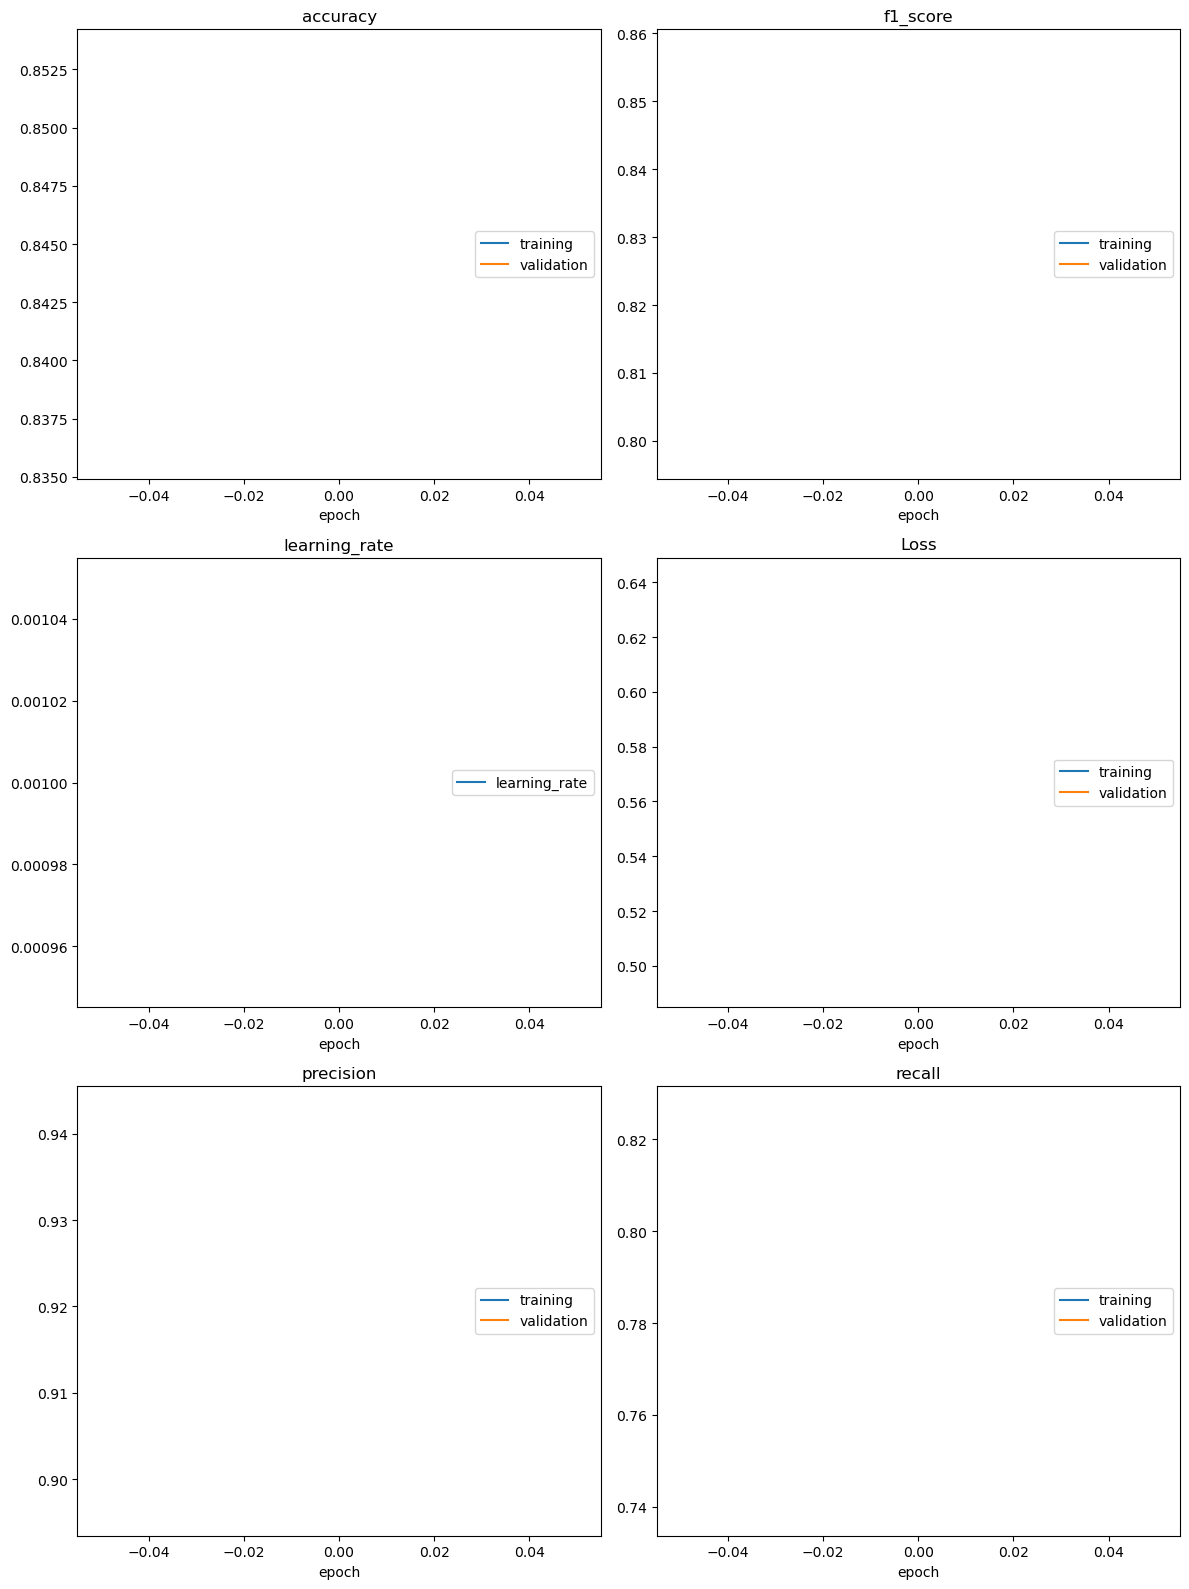

accuracy
	training         	 (min:    0.836, max:    0.836, cur:    0.836)
	validation       	 (min:    0.853, max:    0.853, cur:    0.853)
f1_score
	training         	 (min:    0.797, max:    0.797, cur:    0.797)
	validation       	 (min:    0.858, max:    0.858, cur:    0.858)
learning_rate
	learning_rate    	 (min:    0.001, max:    0.001, cur:    0.001)
Loss
	training         	 (min:    0.642, max:    0.642, cur:    0.642)
	validation       	 (min:    0.492, max:    0.492, cur:    0.492)
precision
	training         	 (min:    0.943, max:    0.943, cur:    0.943)
	validation       	 (min:    0.896, max:    0.896, cur:    0.896)
recall
	training         	 (min:    0.738, max:    0.738, cur:    0.738)
	validation       	 (min:    0.827, max:    0.827, cur:    0.827)
911/911 ━━━━━━━━━━━━━━━━━━━━ 192s 182ms/step - accuracy: 0.7033 - f1_score: 0.5939 - loss: 1.1826 - precision: 0.9289 - recall: 0.5185 - val_accuracy: 0.8533 - val_f1_score: 0.8576 - val_loss: 0.4923 - val_precision: 0.8

In [18]:
history = inception.fit(X_train, y_train, X_val, y_val)

dict_keys(['accuracy', 'f1_score', 'loss', 'precision', 'recall', 'val_accuracy', 'val_f1_score', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])


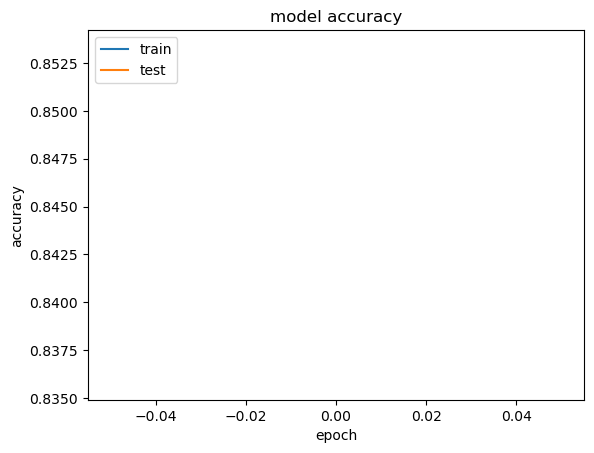

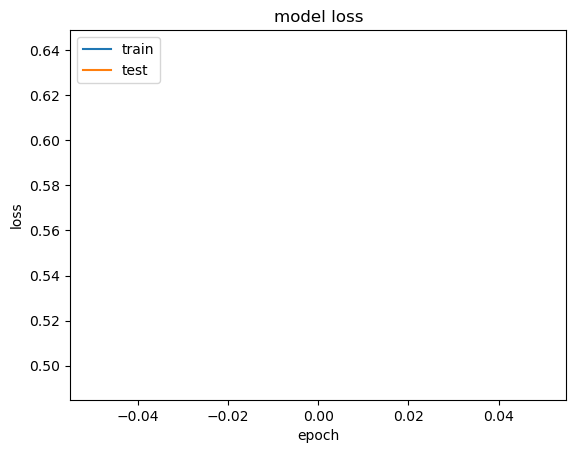

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

#%% visualize training
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('{}_{}_accuracy.png'.format(model_name, date),bbox_inches='tight')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('{}_{}_loss.png'.format(model_name, date), bbox_inches='tight')
plt.show()

In [20]:
inception.model.load_weights("../best_weights.keras")

In [21]:
inception.model.evaluate(X_val, y_val)

214/214 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.8344 - f1_score: 0.8405 - loss: 0.5433 - precision: 0.8819 - recall: 0.8095


[0.492305189371109,
 0.8533411026000977,
 0.8958036303520203,
 0.8271676898002625,
 0.8568307757377625]

In [22]:
y_hat = inception.model.predict(X_val, batch_size = BATCH_SIZE, verbose = 1)

107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step


In [23]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

def ROC_plot(y_true_ohe, y_hat_ohe, label_encoder, n_classes):    
    lw = 2
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_ohe[:, i], y_hat_ohe[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
                                  
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_ohe.ravel(), y_hat_ohe.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.figure(figsize=(20,20))
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(list(label_encoder.keys())[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("multiclass characteristic")
    plt.legend(loc="lower right")
    plt.show()

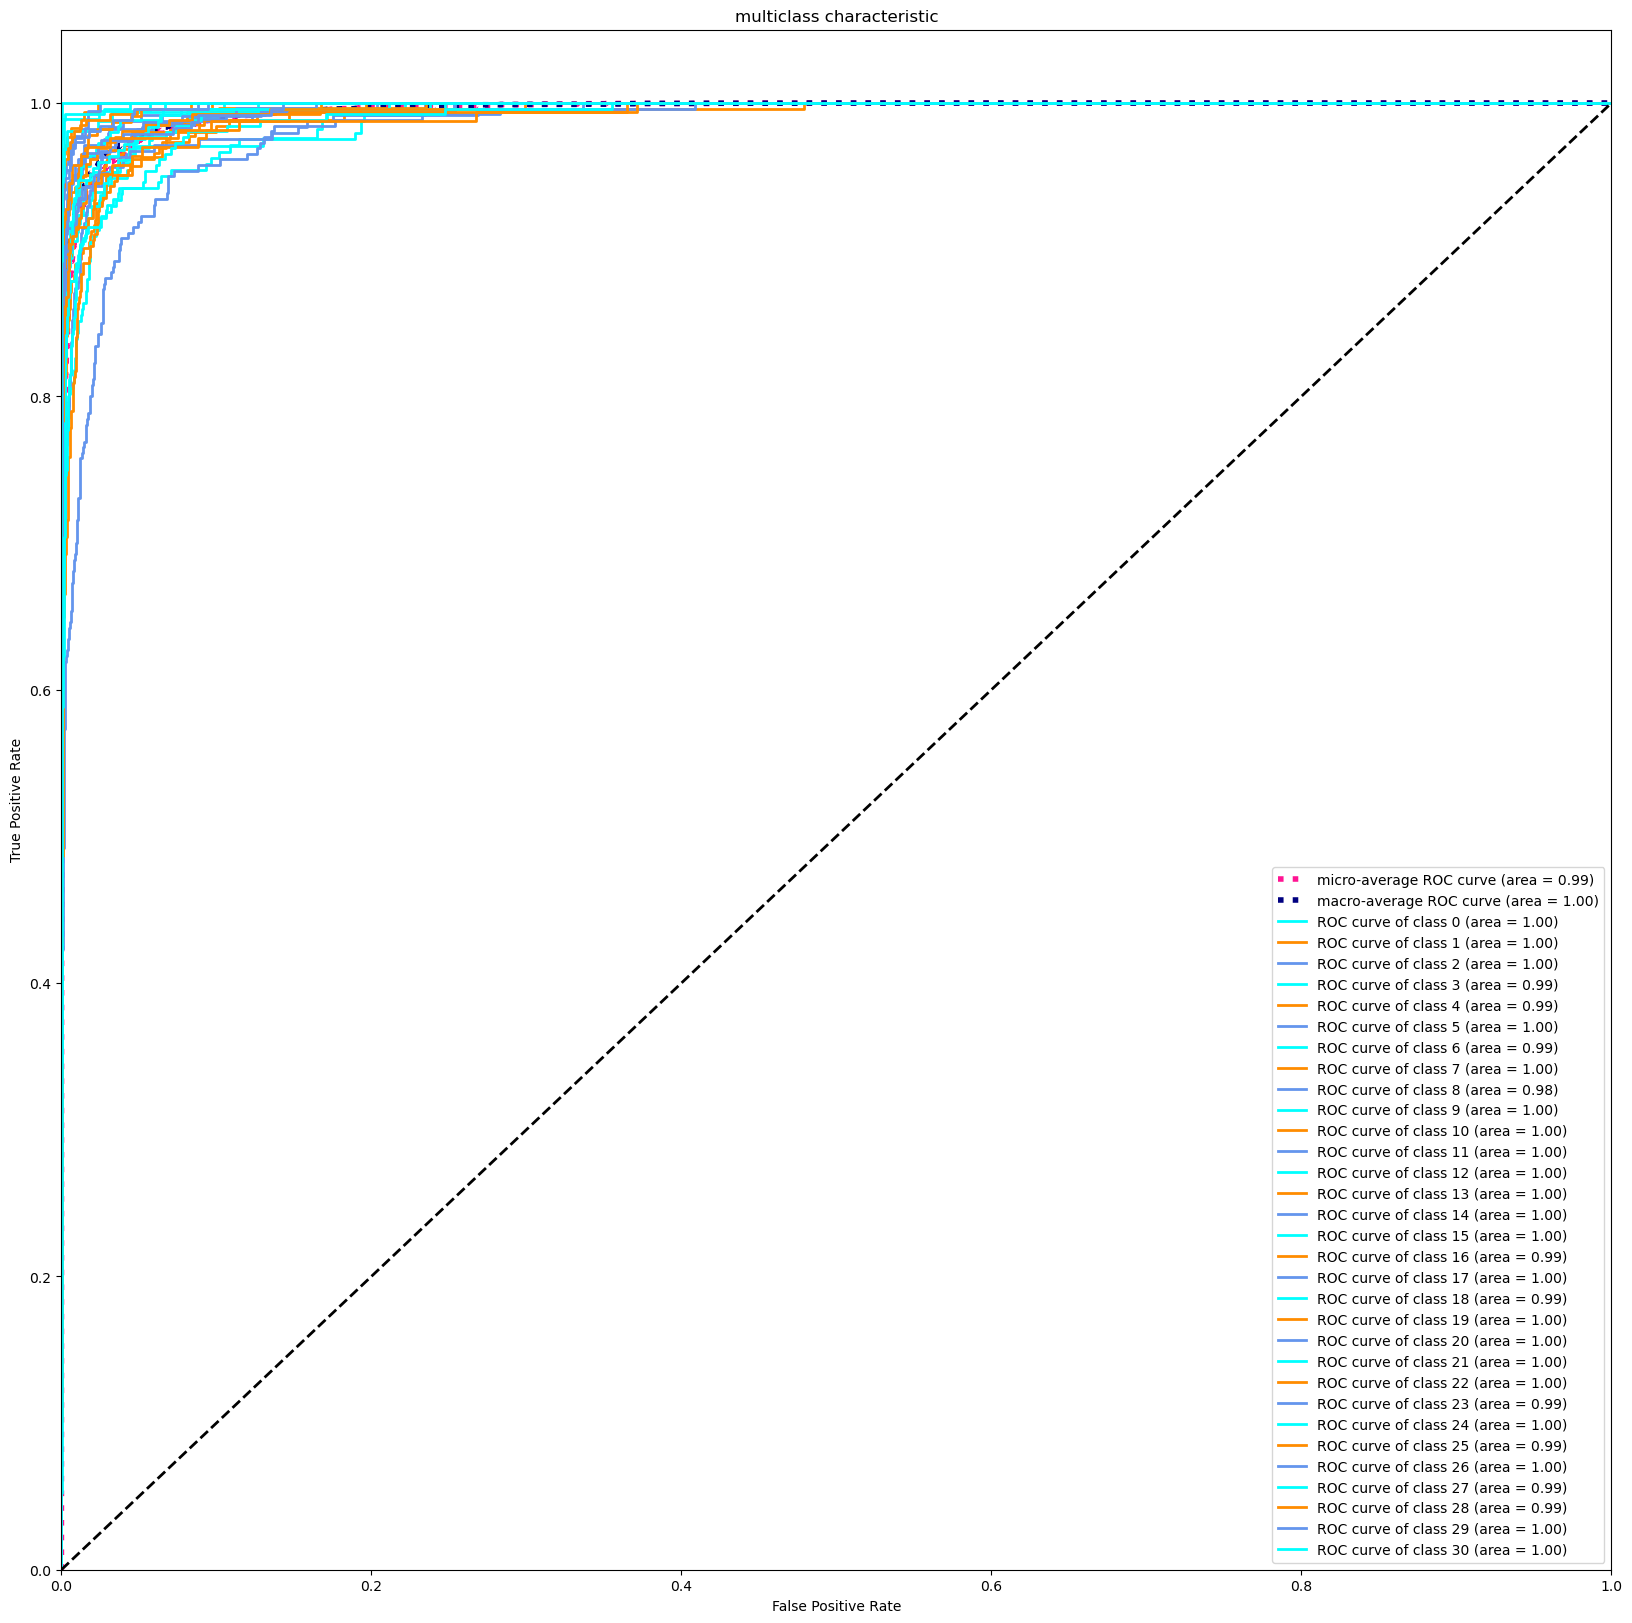

In [24]:
ROC_plot(y_val, y_hat, classes_index, NB_CLASSES)

In [25]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix, classification_report, precision_score, recall_score
from sklearn.metrics import f1_score as f1_score_rep
import seaborn as sn
import pandas as pd


def print_score(y_pred, y_real, label_encoder):
    print("Accuracy: ", accuracy_score(y_real, y_pred))
    print("Precision:: ", precision_score(y_real, y_pred, average="micro"))
    print("Recall:: ", recall_score(y_real, y_pred, average="micro"))
    print("F1_Score:: ", f1_score_rep(y_real, y_pred, average="micro"))

    print()
    print("Macro precision_recall_fscore_support (macro) average")
    print(precision_recall_fscore_support(y_real, y_pred, average="macro"))

    print()
    print("Macro precision_recall_fscore_support (micro) average")
    print(precision_recall_fscore_support(y_real, y_pred, average="micro"))

    print()
    print("Macro precision_recall_fscore_support (weighted) average")
    print(precision_recall_fscore_support(y_real, y_pred, average="weighted"))
    
    print()
    print("Confusion Matrix")
    cm = confusion_matrix(y_real, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, index = [i for i in label_encoder],
                  columns = [i for i in label_encoder])
    plt.figure(figsize = (20,20))
    sn.heatmap(df_cm, annot=True)

    print()
    print("Classification Report")
    print(classification_report(y_real, y_pred, target_names=label_encoder))

Accuracy:  0.8533411317444071
Precision::  0.8533411317444071
Recall::  0.8533411317444071
F1_Score::  0.8533411317444071

Macro precision_recall_fscore_support (macro) average
(0.8790328641721284, 0.8618585043420083, 0.8590262942790229, None)

Macro precision_recall_fscore_support (micro) average
(0.8533411317444071, 0.8533411317444071, 0.8533411317444071, None)

Macro precision_recall_fscore_support (weighted) average
(0.8824869427323412, 0.8533411317444071, 0.8569536313868946, None)

Confusion Matrix

Classification Report
              precision    recall  f1-score   support

         bed       0.90      0.82      0.86       197
        bird       0.75      0.91      0.82       162
         cat       0.99      0.89      0.93       168
         dog       0.46      0.95      0.62       170
        down       0.96      0.70      0.81       264
       eight       0.93      0.90      0.91       243
        five       0.98      0.50      0.66       242
        four       0.98      0.81  

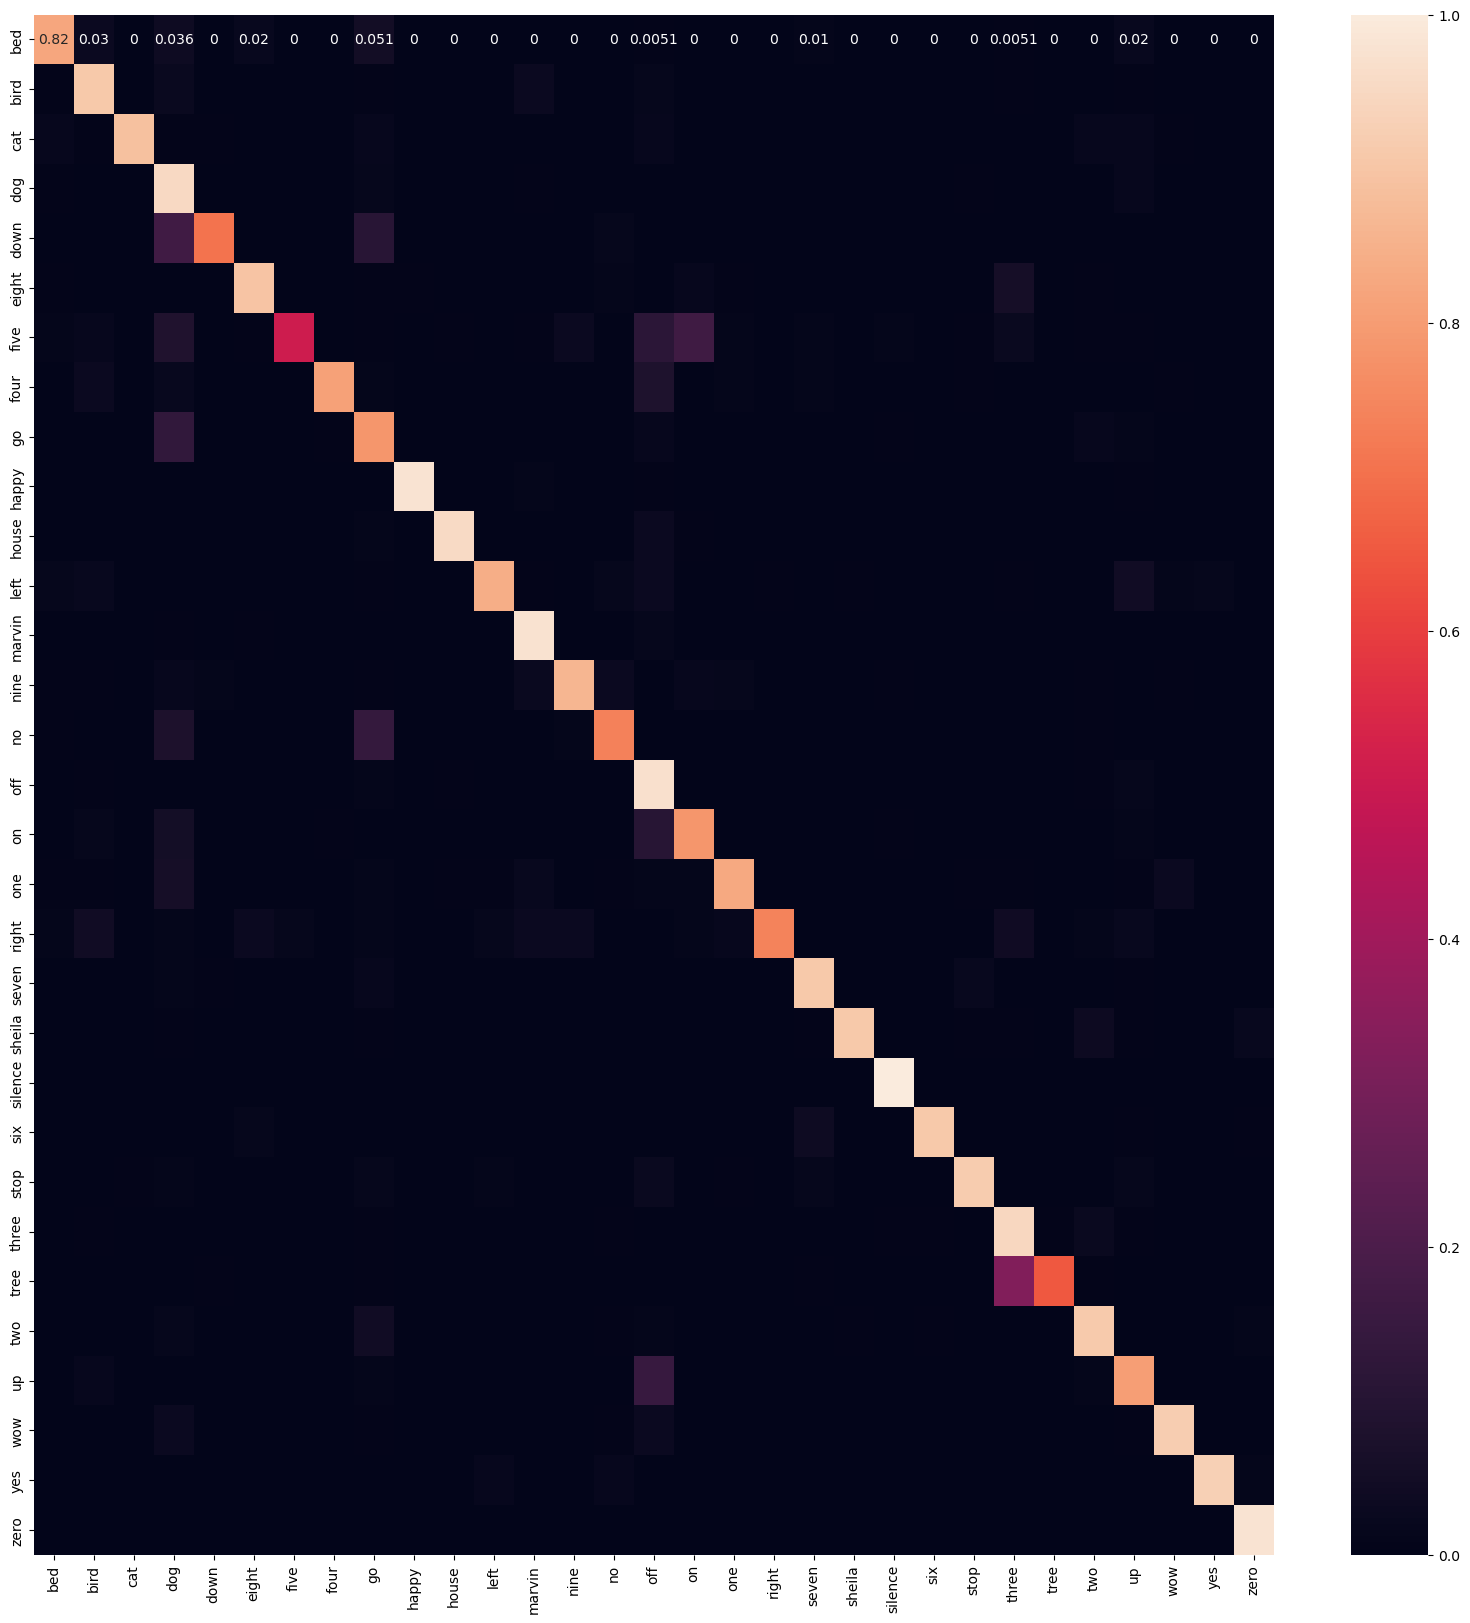

In [26]:
y_hat = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_val, axis=1)

print_score(y_hat, y_true, classes)

